In [1]:
import pandas as pd
import keras
import numpy as np
!pip install dill
import dill
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import warnings
import itertools
import numpy as np
import tensorflow as tf
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, roc_auc_score
from tensorflow.keras.initializers import HeNormal, LecunNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.7 MB/s eta 0:00:00


In [2]:
!gdown 108Rg2FdrnQuh2O_klrQWalZI7orvN5fj
df = pd.read_excel("/content/Diagnostics.xlsx")
df.head()

Downloading...
From: https://drive.google.com/uc?id=108Rg2FdrnQuh2O_klrQWalZI7orvN5fj
To: /content/Diagnostics.xlsx
100% 832k/832k [00:00<00:00, 43.3MB/s]


,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


In [3]:
df_1 = df.drop(columns=['FileName', 'Beat'])
df_1

,Rhythm,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,AFIB,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,SB,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,SA,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,SB,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,AF,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,SVT,80,FEMALE,196,73,168,284,513,258,244,32,177,261,319
10642,SVT,81,FEMALE,162,81,162,294,482,110,-75,27,173,254,320
10643,SVT,39,MALE,152,92,152,340,540,250,38,25,208,284,378
10644,SVT,76,MALE,175,178,128,310,529,98,-83,29,205,269,360


In [4]:
df_1['Rhythm'] = df['Rhythm'].replace({"AF":0, "AFIB":0, "SVT":1, "AT":1, "SAAWR":1, "ST":1,
"AVNRT":1, "AVRT":1, "SB":2, "SA":3, "SR":3})
df_1

<ipython-input-4-1cbd04af9b7c>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_1['Rhythm'] = df['Rhythm'].replace({"AF":0, "AFIB":0, "SVT":1, "AT":1, "SAAWR":1, "ST":1,


,Rhythm,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,0,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,2,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,3,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,2,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,0,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,1,80,FEMALE,196,73,168,284,513,258,244,32,177,261,319
10642,1,81,FEMALE,162,81,162,294,482,110,-75,27,173,254,320
10643,1,39,MALE,152,92,152,340,540,250,38,25,208,284,378
10644,1,76,MALE,175,178,128,310,529,98,-83,29,205,269,360


In [5]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

encoder = OneHotEncoder(sparse_output=False)

one_hot = encoder.fit_transform(df_1[['Gender']])

df_encoded = pd.DataFrame(one_hot, columns=encoder.get_feature_names_out(['Gender']))

# Concatenazione con il DataFrame originale
df_1 = pd.concat([df_1, df_encoded], axis=1)

df_1 = df_1.drop(columns=['Gender', "Gender_FEMALE"])

df_1

,Rhythm,PatientAge,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset,Gender_MALE
0,0,85,117,234,114,356,496,81,-27,19,208,265,386,1.0
1,2,59,52,52,92,432,401,76,42,8,215,261,431,0.0
2,3,20,67,67,82,382,403,88,20,11,224,265,415,0.0
3,2,66,53,53,96,456,427,34,3,9,219,267,447,1.0
4,0,73,162,162,114,252,413,68,-40,26,228,285,354,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,1,80,196,73,168,284,513,258,244,32,177,261,319,0.0
10642,1,81,162,81,162,294,482,110,-75,27,173,254,320,0.0
10643,1,39,152,92,152,340,540,250,38,25,208,284,378,1.0
10644,1,76,175,178,128,310,529,98,-83,29,205,269,360,1.0


In [6]:
from sklearn.model_selection import train_test_split

X = df_1.drop(columns=["Rhythm"])
y = df_1["Rhythm"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3, # train:test ratio 7:3
                                                    stratify=y, # grants equal labels division
                                                    random_state = 13)


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_train)

X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns, index=X_train.index)  # Keep original columns and index

In [8]:
X_scaled_test = scaler.transform(X_test)
# Convert the scaled NumPy array back to a pandas DataFrame
X_scaled_test = pd.DataFrame(X_scaled_test, columns=X_test.columns, index=X_test.index)

In [27]:
X_scaled.iloc[0]

,333
PatientAge,0.553191
VentricularRate,0.628571
AtrialRate,0.824299
QRSDuration,0.193277
QTInterval,0.250804
QTCorrected,0.423290
RAxis,0.401114
TAxis,0.415042
QRSCount,0.647059
QOnset,0.814815


In [9]:
def create_model(nhid1=100,
                 nhid2=50,
                 num_layers=2,
                 learning_rate=0.001,
                 dropout_rate=0,
                 hid_act='leaky_relu',
                 loss='sparse_categorical_crossentropy'):

    model = Sequential()
    model.add(Dense(nhid1, input_shape=(13,), activation=hid_act)) # If you remove beat, shape = 13
    for _ in range(num_layers - 1):
        model.add(BatchNormalization())
        model.add(Dense(nhid2, activation=hid_act))
        model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=loss)

    return model

In [ ]:
from sklearn.metrics import accuracy_score

# Sanity Check
model = create_model()
model.fit(X_scaled, y_train, epochs=10, batch_size=16, verbose=0)

pred = model.predict(X_scaled_test)
pred_labels = np.argmax(pred, axis=1)
acc = accuracy_score(y_test, pred_labels)

print(acc)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
0.8469004383218535


In [ ]:
import tensorflow as tf
if len(tf.config.list_physical_devices('GPU')) == 0:
  raise SystemError('GPU device not found')

In [ ]:
warnings.filterwarnings('ignore')

nhid1 = [100]
nhid2 = [50]
num_layers = [4]
lr = [10**-3]
batch_size = [16]
dropout_rate = [0.1]

k_folds = 2

max_f1_score = -1
max_f1_model_config = None

for n_units, n_units2, layers, batches, l_rates, d_rates in itertools.product(nhid1, nhid2, num_layers, batch_size, lr, dropout_rate):

    fold_f1_scores = []
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=13)

    for train_index, val_index in kf.split(X_scaled):
        X_train_fold, X_val_fold = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model = create_model(n_units, n_units2, layers, l_rates, d_rates, hid_act='relu', loss='sparse_categorical_crossentropy')
        model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=batches, verbose=0)

        pred = model.predict(X_val_fold)
        pred_labels = np.argmax(pred, axis=1)

        f1_macro = f1_score(y_val_fold, pred_labels, average='macro')
        fold_f1_scores.append(f1_macro)

    mean_f1_score = np.mean(fold_f1_scores)
    print(f"Configuration: (n_units, n_units2, layers, l_rates, d_rates, batches): "
          f"{(n_units, n_units2, layers, l_rates, d_rates, batches)} -> mean F1-macro score: {mean_f1_score}")

    if mean_f1_score > max_f1_score:
        max_f1_score = mean_f1_score
        max_f1_model_config = (n_units, n_units2, layers, l_rates, d_rates, batches)

print(f"Max mean F1-macro score: {max_f1_score} with configuration {max_f1_model_config}")

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Configuration: (n_units, n_units2, layers, l_rates, d_rates, batches): (100, 50, 4, 0.001, 0.1, 16) -> mean F1-macro score: 0.8557391712806832
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Configuration: (n_units, n_units2, layers, l_rates, d_rates, batches): (100, 50, 4, 0.001, 0.15, 16) -> mean F1-macro score: 0.8099323563097319
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Configuration: (n_units, n_units2, layers, l_rates, d_rates, batches): (100, 50, 4, 0.008, 0.1, 16) -> mean F1-macro score: 0.8118863465453189
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Configuration: (n_units, n_units2, layers, l_rates, d_rates, batches): (100, 50, 4, 0.008, 0.15, 16) -> mean F1-macro score: 0.7926885371898349
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Configuration: (

In [ ]:
dill.dump(max_f1_model_config, open('model.pkl', 'wb'))

NameError: name 'max_f1_model_config' is not defined

In [10]:
max_f1_model_config = dill.load(open('model.pkl', 'rb'))

In [36]:
hid_act = 'leaky_relu'
loss = 'sparse_categorical_crossentropy'
initializer = LecunNormal()
early_stopping = EarlyStopping(monitor='loss',
                               patience=80,
                               restore_best_weights=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                   factor=0.5,
                                                   patience=10,# 20
                                                   min_lr=1e-6,
                                                   cooldown=10)

nhid1, nhid2, num_layers, learning_rate, dropout_rate, batch_size = max_f1_model_config

best_model = Sequential()
best_model.add(Dense(nhid1, input_shape=(13,), activation=hid_act, kernel_initializer = initializer)) # If remove beat, shape =13
for _ in range(num_layers - 1):
    best_model.add(BatchNormalization())
    best_model.add(Dense(nhid2, activation=hid_act, kernel_initializer = initializer))
    best_model.add(BatchNormalization())
    best_model.add(Dropout(dropout_rate))
best_model.add(Dense(4, activation='softmax'))
best_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=loss)

best_model.fit(X_scaled, y_train,
               epochs=800,
               batch_size = batch_size,
               verbose=0,
               callbacks= [early_stopping, lr_schedule])

pred = best_model.predict(X_scaled_test)
pred_labels = np.argmax(pred, axis=1)
f_1 = f1_score(y_test, pred_labels, average='macro')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [37]:
print(f_1)

0.9227219224629701


In [38]:
print("\nClassification Report:")
print(classification_report(y_test, pred_labels))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       668
           1       0.90      0.88      0.89       692
           2       0.99      0.99      0.99      1167
           3       0.93      0.96      0.94       667

    accuracy                           0.93      3194
   macro avg       0.92      0.92      0.92      3194
weighted avg       0.93      0.93      0.93      3194



In [43]:
best_model.save('best_model.keras')


Confusion Matrix:
[[ 570   58    7   33]
 [  66  612    4   10]
 [   3    0 1158    6]
 [  15    7    4  641]]


<Axes: >

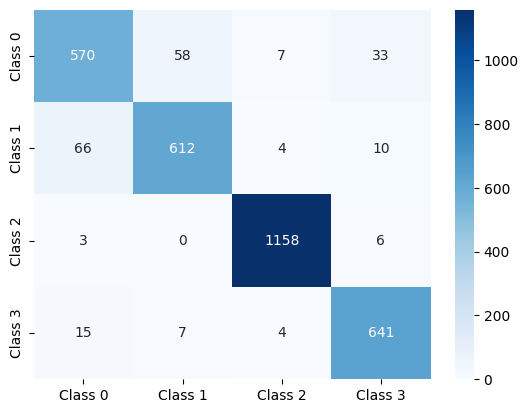

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_test, pred_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix using Seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"], yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])

In [40]:
from sklearn.preprocessing import LabelBinarizer

auc_score = roc_auc_score(y_test, pred, average='macro', multi_class='ovr')

print(f"AUC (Macro Average): {auc_score}")


AUC (Macro Average): 0.9886003329629056


In [41]:
for i in range(4):  # Loop over each class
    auc_class = roc_auc_score(y_test == i, pred[:, i])
    print(f"AUC for class {i}: {auc_class}")

AUC for class 0: 0.9773742301620038
AUC for class 1: 0.984945569555916
AUC for class 2: 0.9982244836100814
AUC for class 3: 0.9938570485236211


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


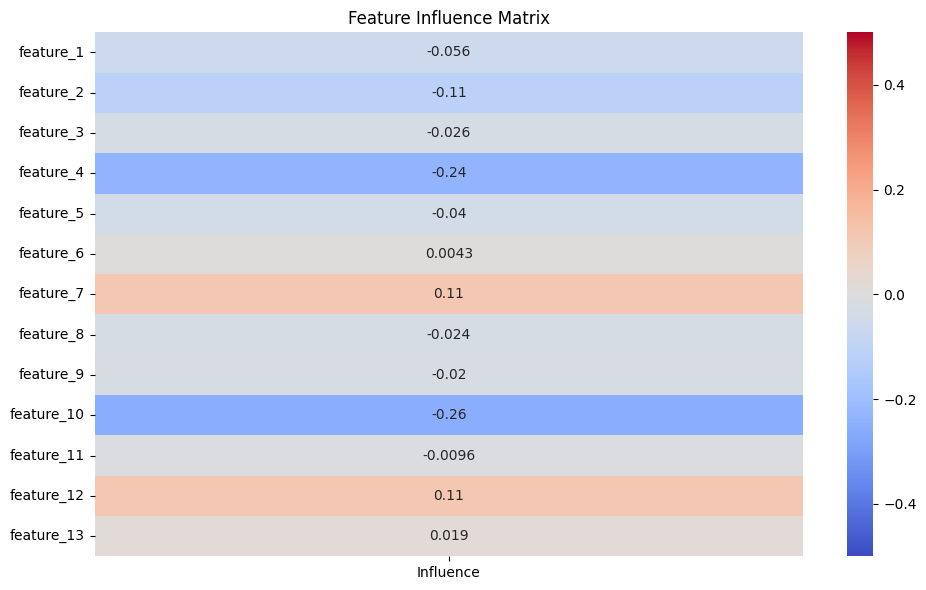

Feature Influence matrix:
            Influence
feature_1   -0.056371
feature_2   -0.114215
feature_3   -0.026363
feature_4   -0.238248
feature_5   -0.040000
feature_6    0.004299
feature_7    0.114215
feature_8   -0.024027
feature_9   -0.019776
feature_10  -0.255876
feature_11  -0.009602
feature_12   0.113848
feature_13   0.018750


In [42]:
def explain_prediction(best_model, sample, feature_names, num_samples=300):
    """
    given the sample we want to explain, we generate a background matrix
    by repeating it num_samples times
    """
    background = np.tile(sample, (num_samples, 1))
    mask = np.random.randint(0, 2, size=background.shape).astype(bool) # a matrix of bool values with dim = background
    random_samples = np.random.normal(0, 1, size=background.shape) # a matrix of random samples with dim = background
    background[mask] = random_samples[mask] # replace the values in background with the random ones at the positions where mask has True

    pred = best_model.predict(background)
    predictions = np.argmax(pred, axis = 1) # after perturbing the background, take the predictions

    importances = []
    '''
    importance of a feature is the difference between the mean of the
    predictions when the feature is original and the mean of the predictions
    when the feature is masked
    '''
    for i in range(len(sample)):
        importance = np.mean(predictions[~mask[:, i]]) - np.mean(predictions[mask[:, i]])
        importances.append(importance)
    '''
    positive importance --> masking leads to more 0 predictions
    negative importance --> masking leads to more 1 predictions
    '''
    return pd.Series(importances, index=feature_names)

def create_feature_matrix(importances):
    influence_matrix = pd.DataFrame(index=importances.index, columns=['Influence'])
    influence_matrix['Influence'] = importances
    return influence_matrix # create a matrix with a single column, containing the importances

def plot_feature_matrix(influence_matrix):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    sns.heatmap(influence_matrix, annot=True, cmap='coolwarm', center=0, vmin=-0.5, vmax=0.5)
    plt.title('Feature Influence Matrix')
    plt.tight_layout()
    plt.show() # visualize the matrix using a Seaborn heatmap

sample_to_explain = X_scaled.iloc[0] # choose a sample to explain (we try the first one)
feature_names = [f'feature_{i+1}' for i in range(sample_to_explain.shape[0])]

importances = explain_prediction(best_model, sample_to_explain, feature_names)

influence_matrix = create_feature_matrix(importances)
plot_feature_matrix(influence_matrix)
'''
warm color --> masking leads to more 0 predictions (feature useful for positive prediction)
cool color --> masking leads to more 1 predictions (feature useful for negative prediction)
gray --> no great difference between unmasked and masked prediction
'''
print("Feature Influence matrix:")
print(influence_matrix)